## Проект e-commerce: вариант 1 
**Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:**

*1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

*2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

*3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

*4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

*5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

*6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.


In [ ]:
import pandas as pd
import numpy as np
from operator import attrgetter
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/olist_customers_dataset.csv')
items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/olist_order_items_dataset.csv',parse_dates=['shipping_limit_date'])
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/olist_orders_dataset.csv', \
                     parse_dates=['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'])

In [3]:
# order_approved_at = NaN и посмотрим на значения order_status
(orders[orders.order_approved_at.isna()]
        .order_status
        .value_counts())

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [4]:
# canceled и created логично не считать покупками, а вот delivered?
delivered_not_approved = (
    orders.query('order_approved_at.isna() and order_status == "delivered"'))
delivered_not_approved

# судя по всем это удачные покупки, но без даты в order_approved_at

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [5]:
# order_approved_at != NaN и посмотрим на значения order_status
(orders[orders.order_approved_at.isna() == False]
        .order_status
        .value_counts())
#Только нет created

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

In [6]:
# Получается покапкой считаем все заказы, кроме created,unavailable и canceled считаем покупкой

## 1 Задание
объединяем датафреймы customer и orders по customer_id и считаем customers кто совершил покупку только 1 раз

In [7]:


no_purchases = ['created', 'unavailable', 'canceled']
merge_customer_and_orders = orders.merge(customers, how='left',on='customer_id')
count_customers = merge_customer_and_orders.query('order_status not in @no_purchases').groupby('customer_unique_id')\
    .agg({'customer_id':'count'}).sort_values('customer_id').reset_index().groupby('customer_id').agg({'customer_unique_id':'count'}) \
    .query('customer_id == 1')
count_customers

,customer_unique_id
customer_id,
1,92099


# 2 Задание  
* сколько заказов в месяц не доставляются в разбивке по причинам?

In [8]:

# Все заказы !=  delivered будем считать не доставленными 
orders_1 = orders.query('order_status != "delivered"')
orders_1['Month'] = orders_1.order_estimated_delivery_date.dt.strftime("%Y-%m")
orders_1.groupby(['order_status','Month']).agg({'order_id':'count'}).reset_index()\
    .groupby('order_status').agg({'order_id':'mean'}).round().reset_index().sort_values('order_id', ascending = False)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,order_status,order_id
5,shipped,48.0
6,unavailable,29.0
1,canceled,24.0
4,processing,16.0
3,invoiced,15.0
2,created,2.0
0,approved,1.0


# 3 задание 
По каждому товару определить, в какой день недели товар чаще всего покупается.

In [9]:
#3 По каждому товару определить, в какой день недели товар чаще всего покупается.
merge_items_and_orders = orders.merge(items,on='order_id')

merge_items_and_orders = merge_items_and_orders.sort_values('order_approved_at') \
.query('order_status not in @no_purchases')

merge_items_and_orders ['Day']= merge_items_and_orders.order_purchase_timestamp.dt.day_name()
# функция для определения наиболее частого дня недели
def get_weekdays(weekdays):
    max_vals = weekdays.value_counts().max()
    weekday_list = (weekdays 
            .value_counts()[weekdays.value_counts() == max_vals] 
            .index 
            .tolist())
    return ', '.join(weekday_list)

purchase_weekday_by_product = merge_items_and_orders \
        .groupby(['order_id', 'product_id'], as_index=False).agg({'Day': 'first'})\
        .groupby('product_id', as_index=False).agg({'Day': lambda x: get_weekdays(x)})

In [10]:
purchase_weekday_by_product

,product_id,Day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,"Wednesday, Friday"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32724,fff6177642830a9a94a0f2cba5e476d1,"Saturday, Sunday"
32725,fff81cc3158d2725c0655ab9ba0f712c,Monday
32726,fff9553ac224cec9d15d49f5a263411f,Friday
32727,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


In [11]:
print(orders.order_id.nunique()) # кол-во уникальных значений в заказах
print(orders.shape[0]) # размер заказов
print(items.order_id.nunique()) # колв-о уникальных занчений в items
print(items.shape[0]) # размер items

99441
99441
98666
112650


In [12]:
#Посмотрим на order_id, отсутствующие в items, но присутствующие в orders
# список order_id, которых нет в order_items
order_id_ = orders.query('order_id not in @items.order_id.unique()').order_id

# строки с order_id по которым нет данных в order_items
order_id = orders.query('order_id in @order_id_')
order_id.shape[0]

775

In [13]:
order_id.order_status.value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [14]:
orders.query('order_status == "unavailable"').shape[0]

609

In [15]:
order_id[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']].isna().sum()

order_purchase_timestamp           0
order_approved_at                146
order_delivered_carrier_date     774
order_delivered_customer_date    775
order_estimated_delivery_date      0
dtype: int64

In [16]:
#Все значения order_delivered_customer_date пропущены и во всех значениях order_status нет положительных статусов заказа

In [17]:
# order_id некупленных товаров
no_purchases_id = (orders.query('order_status == @no_purchases').order_id)

# количетсво строк с заказами в order_items, которые мы не считаем покупками
(items.query('order_id in @no_purchases_id').shape[0])

549

In [18]:
# Почти все строки которых нет в items со статусами недоставлен или отменен, это не доставленные товары

In [19]:
# объединяем 3 датафрейма для расчетов

df_full_1 = customers.merge(orders, on='customer_id')
df_full = df_full_1.merge(items,on='order_id')

In [20]:
df_full.shape[0]

112650

In [21]:
items.shape[0]

112650

In [22]:
df_full = df_full.query('order_status not in @no_purchases')
df_full_1 = df_full.query('order_status not in @no_purchases')

# 4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

In [23]:

df_full['Y_M_order'] = df_full.order_purchase_timestamp.dt.to_period('M')
mean_per_week_df = (df_full
        .groupby(['Y_M_order', 'customer_unique_id'], as_index=False)             # группировка по год месяц и пользователь
        .agg({'order_purchase_timestamp': 'count'})                               # считаем количество покупок в месяц на пользователя
        .assign(weeks_in_month = lambda i: i.Y_M_order.dt.daysinmonth / 7)        # количество недель в месяце
        .rename(columns={'order_purchase_timestamp': 'order_per_month'})         # переименовываем колонку с подсчётом
        .assign(mean_orders_per_week = lambda i: i.order_per_month / i.weeks_in_month)  # делим количество заказов в месяц на количество недель в месяце      
)
mean_per_week_df

,Y_M_order,customer_unique_id,order_per_month,weeks_in_month,mean_orders_per_week
0,2016-09,830d5b7aaa3b6f1e9ad63703bec97d23,3,4.285714,0.700000
1,2016-09,b7d76e111c89f7ebf14761390f0f7d17,2,4.285714,0.466667
2,2016-10,0032c76b20340da25249092a268ce66c,1,4.428571,0.225806
3,2016-10,01f156677184504063bd19739f924af1,1,4.428571,0.225806
4,2016-10,0313291a6f4f16df04dcf819d88c38ef,1,4.428571,0.225806
...,...,...,...,...,...
96856,2018-08,ffc4e1cd8aa220763480d0a18157c45d,1,4.428571,0.225806
96857,2018-08,ffe204b1bb8026741b839085b2fd10f2,1,4.428571,0.225806
96858,2018-08,ffec490ab531184a483efe2eedd68908,1,4.428571,0.225806
96859,2018-08,fff96bc586f78b1f070da28c4977e810,1,4.428571,0.225806


# 5 задание
Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [25]:
# количество уникальных пользователей
uniq_customers =df_full.groupby('customer_unique_id').order_id.nunique()
# % пользователей сделавших больше 1 заказа (2,9%)
per_uniq_customers_more_1 =np.sum(uniq_customers > 1) / df_full.order_id.nunique()
per_uniq_customers_more_1

0.029399484719803665

In [26]:

df_full_1['date'] = df_full_1.order_purchase_timestamp.dt.to_period('M')
cohorts =(df_full_1.groupby('customer_unique_id', as_index=False).date.min()  # группируем по пользователям и выбираем колонку с датами, отбираем минимальные колонки для каждого пользователя
             .rename(columns={'date': 'cohort'}))
cohorts_df = (
            cohorts                                             # датасет с когортами
            .merge(df_full_1[['customer_unique_id', 'date']], on='customer_unique_id')   # объединяем с основным датасетом по пользователям
            .sort_values('cohort')                              # сортируем по когортам
            .rename(columns={'date': 'target_action_order_purchase_timestamps'}))     # переименовываем колонку с датами целевых действий
    # сгруппируем по когортам и месяцам покупок и посчитаем количество покупателей на каждый месяц
cohorts_df = (
        cohorts_df
            .groupby(['cohort', 'target_action_order_purchase_timestamps'], as_index=False)
            .agg(customer_quantity = ('customer_unique_id', 'nunique')))
  # считаем разницу между первой и последующими покупками, добавляем в столбец
cohorts_df['period_number'] = (
        cohorts_df
            .target_action_order_purchase_timestamps                  
            .sub(cohorts_df.cohort)               # вычитаем когорты из времени целевых действий
            .apply(attrgetter('n')))              # передаём атрибут номинальной единицы (т.е. будут те же что и в  period=)
    # строим сводную таблицу
cohort_pivot = cohorts_df.pivot_table(index='cohort', columns='period_number', values='customer_quantity')
    # размер когорты = количество пользователей в нулевой период
cohort_size = cohort_pivot.iloc[:,0]
    
    # строим retention матрицу
retention_matrix = cohort_pivot.div(cohort_size, axis = 0)


In [27]:

ur_style = (retention_matrix
            .style
            .background_gradient(cmap='YlOrRd')          
            .highlight_null('green')                      
            .format("{:.2%}", na_rep=""))                 
ur_style

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.35%,,,0.35%,,0.35%,,0.35%,,0.35%,,0.35%,0.70%,0.70%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.66%,0.40%,0.13%,0.13%,0.27%,0.40%,0.13%,
2017-02,100.00%,0.24%,0.30%,0.12%,0.41%,0.12%,0.24%,0.18%,0.12%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.25%,0.34%,0.25%,0.03%,0.20%,0.23%,,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.39%,0.35%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,,


In [28]:
# когорта с максимальным retention на третий месяц 
# в период с января по декабрь 2017 г.
print(retention_matrix.loc['2017-01':'2017-12', 3].idxmax())

2017-05


# 6 задание
**Часто для качественного анализа аудитории использую подходы, основанные на сегментации. **
**Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.**

В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты,
F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. 
Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, 
frequency и monetary для интерпретации этих кластеров. 
Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, 
frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [30]:
# Сегодня на дворе 2022 год, первые покупки в нашем дф были в 2016 а последние в 2018, следоватльно разница между
# сегодня и последней датой больше чем разница между первой и последней покупкой в дф, поэтому будем думать что 
# сегодня дата последней покупки в дф
today_date = df_full.order_purchase_timestamp.max()
today_date

Timestamp('2018-09-03 09:06:57')

In [31]:
# отсчитаем 1 год от даты
start_date = today_date - pd.Timedelta(365, unit='day')
start_date

Timestamp('2017-09-03 09:06:57')

In [32]:
#recency - кол-во дней  с момента последнего заказа 
#frequency - среднее кол-во заказов на юзера
#monetary - средняя сумма чека

In [33]:
# датафрэём для анализа за период
rfm_1_years = (
    df_full.copy()
    .query('order_purchase_timestamp >= @start_date') 
    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',
            'customer_unique_id': 'first',
            'order_purchase_timestamp': 'max'})
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'mean',                              
            'order_id': 'count',                          
            'order_purchase_timestamp': 'max'})           
        .rename(columns={
            'price': 'avg_check', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_count',
            'order_purchase_timestamp': 'last_order'})
        .assign(day_diff = lambda x:(today_date.to_period('D') - x.last_order.dt.to_period('D')).apply(attrgetter('n')) # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
))

In [34]:
rfm_1_years.head()

,customer,avg_check,purchases_count,last_order,day_diff
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,119
2,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,326
3,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,293
4,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,2018-04-05 19:33:16,151


In [35]:
rfm_1_years.describe()

,avg_check,purchases_count,day_diff
count,73071.000000,73071.000000,73071.000000
mean,137.788142,1.027439,176.685635
std,207.447816,0.186223,98.868528
min,0.850000,1.000000,0.000000
25%,47.000000,1.000000,93.000000
50%,88.000000,1.000000,176.000000
75%,149.900000,1.000000,264.000000
max,13440.000000,11.000000,365.000000


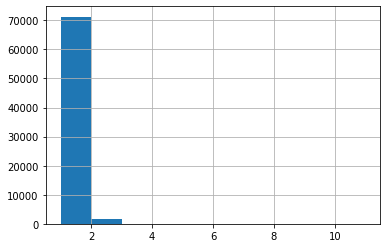

In [36]:
rfm_1_years.purchases_count.hist()

In [37]:
#frequency - среднее кол-во заказов на юзера - большинство делали 1 покупку (97%)
# присутсвуют выбросы, но рукводствуясь логикой можно разделить на 3 кластера от 0 до 1, от 1 до 2 и 2 и более

In [38]:
rfm_1_years.purchases_count.value_counts()

1     71240
2      1709
3        96
4        16
5         5
7         3
11        1
9         1
Name: purchases_count, dtype: int64

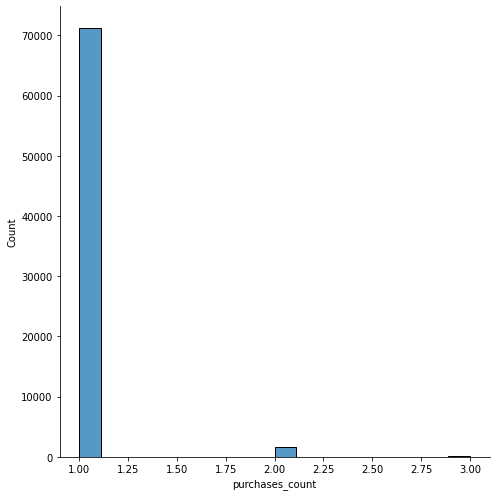

In [39]:
sns.displot(rfm_1_years.purchases_count[rfm_1_years.purchases_count <= 3], height=7)

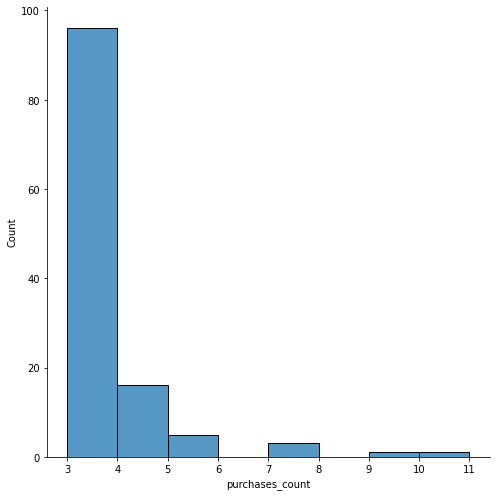

In [40]:
sns.displot(rfm_1_years.purchases_count[rfm_1_years.purchases_count >= 3], height=7)

In [41]:
f_1 = (1, 2, 3)
f_bins =[0, 1, 2, 11]

f = (pd.cut(rfm_1_years.purchases_count, 
                   bins=f_bins, 
                   labels = f_1, 
                   right=True, 
                   include_lowest=True))


In [42]:
#Monetary

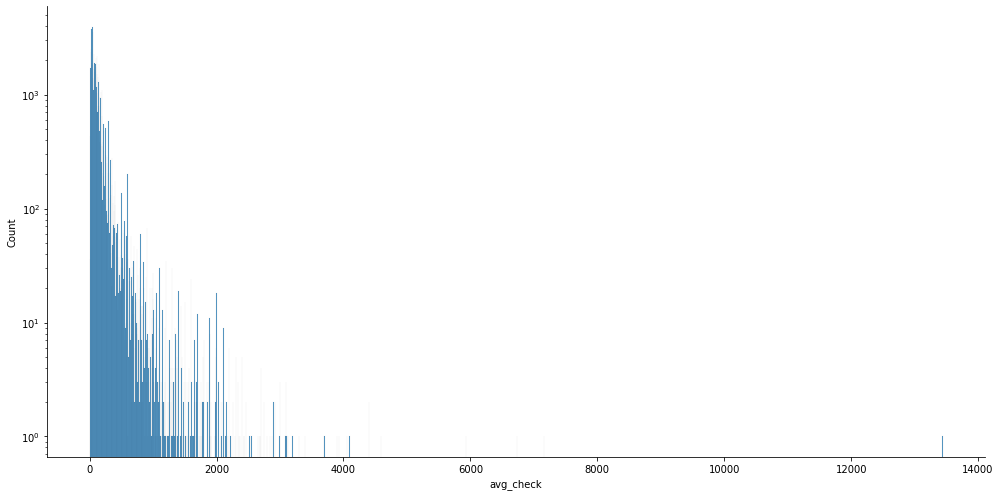

In [43]:
sns.displot(rfm_1_years.avg_check, height=7, aspect=2, log_scale=(False, True))

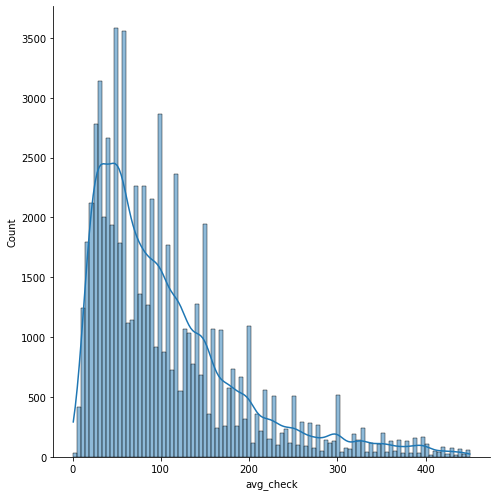

In [44]:
sns.displot(rfm_1_years.avg_check[rfm_1_years.avg_check < 450], height=7, aspect=1, kde=True)

In [45]:
# по графику можно прикинуть - разделить на 3 калсетра от 0 - 79 (45% чеков), 79-270(45% чекво), 270+(около 10%)

In [46]:
rfm_1_years.avg_check[rfm_1_years.avg_check < 79].count()/rfm_1_years.avg_check.count()

0.4520534822296123

In [47]:
(rfm_1_years.avg_check[rfm_1_years.avg_check < 270].count()-rfm_1_years.avg_check[rfm_1_years.avg_check < 79].count())/rfm_1_years.avg_check.count()

0.449508012754718

In [48]:
rfm_1_years.avg_check[rfm_1_years.avg_check > 270].count()/rfm_1_years.avg_check.count()

0.09797320414391482

In [49]:
Monetary = [0.85, 79, 270, 13440]

In [50]:
m1 = (1, 2, 3)
m_bins = Monetary
m = (pd.cut(rfm_1_years.avg_check, 
                   bins=m_bins, 
                   labels = m1, 
                   right=True,
                   include_lowest = True))

In [51]:
#Recency

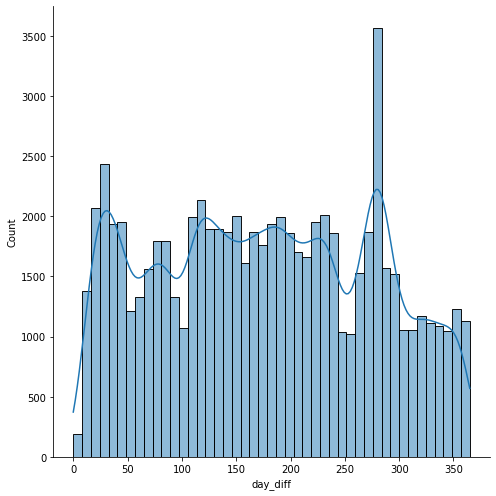

In [52]:
sns.displot(rfm_1_years.day_diff, height=7, aspect=1, kde=True)

In [53]:
# Среднее значение и медиана равны, логично взять для раздения на кластера 33% и 66% перцентили 
rfm_1_years.day_diff.quantile(q=[0.33, 0.66])

0.33    121.0
0.66    228.0
Name: day_diff, dtype: float64

In [54]:
r_1 = (3, 2, 1)
r_bins = [0, 121, 228, 365]

r = (pd.cut(rfm_1_years.day_diff, 
                   bins=r_bins, 
                   labels = r_1, 
                   right=True, 
                   include_lowest=True))


In [55]:
rfm= (rfm_1_years
        .assign(recency   = r,
                frequency = f,
                monetary  = m))

In [56]:
rfm.head()

,customer,avg_check,purchases_count,last_order,day_diff,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,116,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,119,3,1,1
2,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,326,1,1,1
3,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,293,1,1,2
4,0004bd2a26a76fe21f786e4fbd80607f,154.00,1,2018-04-05 19:33:16,151,2,1,2


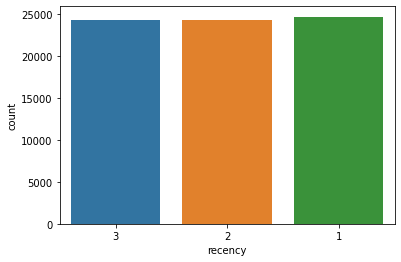

In [57]:
sns.countplot(data=rfm, x='recency')

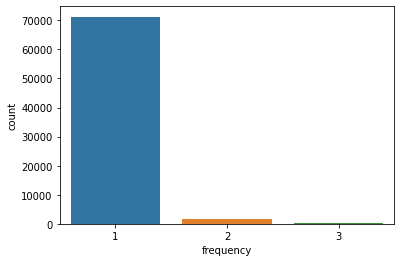

In [58]:
sns.countplot(data=rfm, x='frequency')

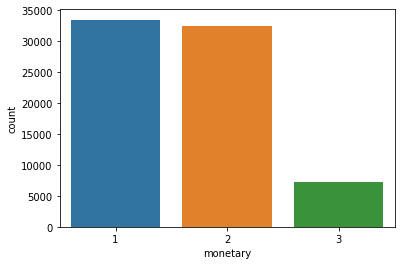

In [59]:
sns.countplot(data=rfm, x='monetary')

In [60]:
# среднее recency по кластерам
avg_recency = (rfm.pivot_table(index='recency', values='day_diff')
        .reset_index()
        .rename(columns={'recency': 'cluster',
                        'day_diff': 'recency'}))
avg_recency

,cluster,recency
0,3,63.397975
1,2,174.422953
2,1,290.134110


In [61]:
# среднее monetary по кластерам
avg_monetary = (rfm.pivot_table(index='monetary', values='avg_check')
        .reset_index()
        .rename(columns={'monetary': 'cluster',
                        'avg_check': 'monetary'}))
avg_monetary

,cluster,monetary
0,1,43.620044
1,2,140.271530
2,3,566.711214


In [62]:
# среднее frequency по кластерам
avg_frequency = (rfm.pivot_table(index='frequency', values='purchases_count')
        .reset_index()
        .rename(columns={'frequency': 'cluster',
                        'purchases_count': 'frequency'}))
avg_frequency

,cluster,frequency
0,1,1.00000
1,2,2.00000
2,3,3.42623


In [63]:
avg_rfm = (
    avg_recency
        .merge(avg_frequency, on='cluster')
        .merge(avg_monetary, on='cluster')
        .sort_values('cluster')
        .reset_index(drop=True))
avg_rfm
#R - recency — перерыв между покупками
#F - frequency — сколько сделали заказов;
#M - monetary — средний чек (взял средний чек т.к. на обущю сумму влияет кол-во покупок, 
#а это мы считаем в frequency )

,cluster,recency,frequency,monetary
0,1,290.134110,1.00000,43.620044
1,2,174.422953,2.00000,140.271530
2,3,63.397975,3.42623,566.711214


In [64]:
rfm['RFM']=rfm.apply(lambda i: str(i.recency) + str(i.frequency) + str(i.monetary), axis=1)

In [67]:
user_count = (rfm
                .groupby('RFM', as_index=False)
                .agg({'customer': 'count'}))

In [69]:
rfm_values = (rfm
        .groupby('RFM', as_index=False)
        .agg({'day_diff':'mean',
             'purchases_count':'mean',
             'avg_check':'mean'})
        .rename(columns={'day_diff':'recency_avg',
                        'purchases_count':'frequency_avg',
                        'avg_check':'monetary_avg'})
        .merge(user_count, on='RFM'))
rfm_values

,RFM,recency_avg,frequency_avg,monetary_avg,customer
0,111,290.197522,1.000000,44.090699,11138
1,112,289.356941,1.000000,140.594771,10618
2,113,293.588479,1.000000,561.860796,2413
3,121,291.172249,2.000000,49.233995,209
4,122,287.514286,2.000000,139.013405,210
5,123,281.119048,2.000000,475.350000,42
6,131,270.000000,3.250000,68.165000,4
7,132,283.555556,3.444444,113.540278,9
8,133,352.000000,3.000000,396.566667,1
9,211,175.366905,1.000000,42.810734,10763


In [73]:
# датафрэйм для RFM-анализа с помощью скрипта RFMizer
rfmizer= (
    df_full
        .groupby('order_id')
        .agg({'order_purchase_timestamp': 'max', 'customer_unique_id': 'first', 'price': 'sum'})  
        .rename(columns={'order_purchase_timestamp': 'order_date', 
                        'customer_unique_id': 'user_id',
                        'price': 'order_value'}))
rfmizer['order_date'] = rfmizer['order_date'].dt.date

rfmizer.head()

,order_date,user_id,order_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.90
00018f77f2f0320c557190d7a144bdd3,2017-04-26,eb28e67c4c0b83846050ddfb8a35d051,239.90
000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.00
00024acbcdf0a6daa1e931b038114c75,2018-08-08,af861d436cfc08b2c2ddefd0ba074622,12.99
00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [74]:
rfmizer.to_csv('rfmizer.csv', encoding='utf8', sep=',', index = False)

In [75]:
borders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/RFM-3-3-3-365-182_borders.csv')
mappings = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/RFM-3-3-3-365-182_mapping.csv')
ratios = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-o-kivokurtsev/MP_1/RFM-3-3-3-365-182_ratios.csv')

In [76]:
borders

,dimension,segment,border
0,frequency,1,2.00
1,frequency,2,3.00
2,monetary,1,57.95
3,monetary,2,125.02
4,recency,1,-229.00
5,recency,2,-121.00


In [79]:
mappings

,user_id,frequency,monetary,recency
0,871766c5855e863f6eccc05f988b23cb,1,2,1
1,eb28e67c4c0b83846050ddfb8a35d051,1,1,1
2,3818d81c6709e39d06b2738a8d3a2474,1,3,1
3,af861d436cfc08b2c2ddefd0ba074622,1,1,3
4,64b576fb70d441e8f1b2d7d446e483c5,0,0,0
...,...,...,...,...
94978,0c9aeda10a71f369396d0c04dce13a64,1,3,2
94979,0da9fe112eae0c74d3ba1fe16de0988b,1,3,3
94980,cd79b407828f02fdbba457111c38e4c4,1,2,1
94981,eb803377c9315b564bdedad672039306,0,0,0


In [80]:
# датафрэём для анализа за весь период
rfm_all_years = (
    df_full.copy()
 
    # сначала сгруппируем по заказам
        .groupby('order_id', as_index=False)                     
        .agg({
            'price': 'sum',
            'customer_unique_id': 'first',
            'order_purchase_timestamp': 'max'})
        .groupby('customer_unique_id', as_index=False)           
        .agg({
            'price': 'mean',                              
            'order_id': 'count',                          
            'order_purchase_timestamp': 'max'})           
        .rename(columns={
            'price': 'avg_check', 
            'customer_unique_id': 'customer',
            'order_id': 'purchases_count',
            'order_purchase_timestamp': 'last_order'})
        .assign(day_diff = lambda x:(today_date.to_period('D') - x.last_order.dt.to_period('D')).apply(attrgetter('n')) # передадим созданной колонке атрибут n, чтобы задать номинальные единицы изменения (дни)
))

In [86]:
mappings.rename(columns={'user_id': 'customer'}, inplace=True)
rfm_rfmizer = rfm_all_years.merge(mappings, on='customer')
rfm_rfmizer

,customer,avg_check,purchases_count,last_order,day_diff,frequency,monetary,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90,1,2018-05-10 10:56:27,116,1,3,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90,1,2018-05-07 11:11:27,119,1,1,3
2,0000f46a3911fa3c0805444483337064,69.00,1,2017-03-10 21:05:03,542,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,25.99,1,2017-10-12 20:29:41,326,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,180.00,1,2017-11-14 19:45:42,293,1,3,1
...,...,...,...,...,...,...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00,1,2017-06-08 21:00:36,452,0,0,0
94979,fffea47cd6d3cc0a88bd621562a9d061,64.89,1,2017-12-10 20:07:56,267,1,2,1
94980,ffff371b4d645b6ecea244b27531430a,89.90,1,2017-02-07 15:49:16,573,0,0,0
94981,ffff5962728ec6157033ef9805bacc48,115.00,1,2018-05-02 15:17:41,124,1,2,2


In [87]:
# среднее recency по кластерам
avg_recency_1 = (rfm_rfmizer.pivot_table(index='recency', values='day_diff')
        .reset_index()
        .rename(columns={'recency': 'cluster',
                        'day_diff': 'recency'}))
avg_recency_1

,cluster,recency
0,0,465.622506
1,1,290.850373
2,2,175.039781
3,3,63.397975


In [88]:
# среднее monetary по кластерам
avg_monetary_1 = (rfm_rfmizer.pivot_table(index='monetary', values='avg_check')
        .reset_index()
        .rename(columns={'monetary': 'cluster',
                        'avg_check': 'monetary'}))
avg_monetary_1

,cluster,monetary
0,0,138.271765
1,1,35.075557
2,2,88.604060
3,3,290.307382


In [89]:
# среднее frequency по кластерам
avg_frequency_1 = (rfm_rfmizer.pivot_table(index='frequency', values='purchases_count')
        .reset_index()
        .rename(columns={'frequency': 'cluster',
                        'purchases_count': 'frequency'}))
avg_frequency_1

,cluster,frequency
0,0,1.026980
1,1,1.015378
2,2,2.064007
3,3,3.869048


In [90]:
avg_rfm_rfmizer = (
    avg_recency_1
        .merge(avg_frequency_1, on='cluster')
        .merge(avg_monetary_1, on='cluster')
        .sort_values('cluster')
        .reset_index(drop=True))
avg_rfm_rfmizer

,cluster,recency,frequency,monetary
0,0,465.622506,1.026980,138.271765
1,1,290.850373,1.015378,35.075557
2,2,175.039781,2.064007,88.604060
3,3,63.397975,3.869048,290.307382


In [91]:
avg_rfm

,cluster,recency,frequency,monetary
0,1,290.134110,1.00000,43.620044
1,2,174.422953,2.00000,140.271530
2,3,63.397975,3.42623,566.711214


In [ ]:
# В целом скрипт дал похожий результат, есть различиня по среднему чеку - но это уже, 
#как говорится, на усмотрение каждого